# Classification

Let's train models with the features we have extracted.

In [1]:
# import dalmatian
import os
import time
import pickle
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



In [2]:
hololens_feature_df = pd.read_pickle("../data/working/hololens_feature_df_30-1.pkl")
print(hololens_feature_df.shape)
hololens_feature_df.head()

(40066, 247)


,participant_id,session_id,cognitive_load,head_position_change_mean,head_position_change_std,head_position_change_median,head_position_change_mad,head_position_change_min,head_position_change_max,head_position_change_range,...,hand_strict_max_contralateral_distance_median,hand_strict_max_contralateral_distance_mad,hand_strict_max_contralateral_distance_min,hand_strict_max_contralateral_distance_max,hand_strict_max_contralateral_distance_range,hand_strict_max_contralateral_distance_iqr,hand_strict_max_contralateral_distance_skew,hand_strict_max_contralateral_distance_kurtosis,hand_strict_max_contralateral_distance_energy,hand_strict_max_contralateral_distance_rms
0,2,0,0,0.001705,0.001200,0.001487,0.000944,0.000069,0.007020,0.006951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,0,0.001724,0.001180,0.001487,0.000925,0.000069,0.007020,0.006951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,0.001668,0.001162,0.001428,0.000902,0.000069,0.007020,0.006951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,0,0,0.001724,0.001242,0.001479,0.000938,0.000069,0.012304,0.012235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0,0,0.001769,0.001261,0.001533,0.000958,0.000069,0.012304,0.012235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
e4_feature_df = pd.read_pickle('../data/working/e4_feature_df_30-1.pkl')
print(e4_feature_df.shape)
e4_feature_df.head()

(40066, 83)


,participant_id,session_id,cognitive_load,bvp_raw_mean,bvp_raw_std,bvp_raw_median,bvp_raw_mad,bvp_raw_min,bvp_raw_max,bvp_raw_range,...,temperature_raw_range,temperature_raw_iqr,temperature_raw_skew,temperature_raw_kurtosis,temperature_raw_energy,temperature_raw_rms,temperature_raw_max_freq,temperature_raw_mean_freq,temperature_raw_entropy,temperature_raw_psd
0,2,0,0,-2.136141,73.394602,-3.982177,56.194244,-230.6975,273.3171,504.0146,...,0.08,0.040,-0.356155,-0.414643,1082.936887,32.908006,0.008333,0.069719,2.706397,0.021003
1,2,0,0,-0.557511,72.573467,-3.534523,55.709491,-230.6975,273.3171,504.0146,...,0.08,0.025,-0.366038,-0.585770,1082.805247,32.906006,0.008333,0.065851,2.666918,0.025845
2,2,0,0,-1.273746,73.004364,-3.534523,56.166926,-230.6975,273.3171,504.0146,...,0.06,0.020,-0.413389,-0.826560,1082.673607,32.904006,0.008333,0.063048,2.637124,0.031030
3,2,0,0,0.632824,72.694216,-1.364120,55.530703,-230.6975,273.3171,504.0146,...,0.06,0.020,-0.328455,-0.834783,1082.585847,32.902672,0.008333,0.061667,2.630544,0.035785
4,2,0,0,1.654274,70.126952,-0.600952,53.766837,-230.6975,273.3171,504.0146,...,0.06,0.020,-0.241801,-0.858808,1082.520033,32.901672,0.008333,0.060922,2.649913,0.039985


In [9]:
combined_feature_df = pd.concat([hololens_feature_df, e4_feature_df.iloc[:, 3:]], axis=1)
combined_feature_df.shape

(40066, 327)

In [78]:
# only fixation features
column_subset = ["cognitive_load"] + [feature for feature in hololens_feature_df.columns if "fixation" in feature]
fixation_feature_df = hololens_feature_df[column_subset]

# only head features
column_subset = ["cognitive_load"] + [feature for feature in hololens_feature_df.columns if "head" in feature]
head_feature_df = hololens_feature_df[column_subset]

# all hand features
column_subset = ["cognitive_load"] + [feature for feature in hololens_feature_df.columns if "hand" in feature]
hand_feature_df = hololens_feature_df[column_subset]

# only combined hand features
column_subset = ["cognitive_load"] + [feature for feature in hand_feature_df.columns if "hand_max" in feature or "hand_strict" in feature]
combined_hand_feature_df = hand_feature_df[column_subset]

## Simple models

In [10]:
def train_model(feature_df):
    feature_df = feature_df.dropna()
    feature_columns = [feature for feature in feature_df.columns if feature not in ['participant_id', 'session_id', 'trial_id', 'cognitive_load']]
    X = feature_df[feature_columns]
    y = feature_df['cognitive_load']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the logistic regression model
    model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000, penalty="l2")
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    importance = np.abs(model.coef_[0]).round(3)
    feature_importance = pd.Series(importance, index=X.columns).sort_values(ascending=False)
    print("Feature Importance:")
    print(feature_importance[:13])

In [11]:
# combined hololens + e4 features
train_model(combined_feature_df)

Confusion Matrix:
[[2296   79]
 [  80 2392]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2375
           1       0.97      0.97      0.97      2472

    accuracy                           0.97      4847
   macro avg       0.97      0.97      0.97      4847
weighted avg       0.97      0.97      0.97      4847

Feature Importance:
fixation_distance_skew                        5.248
fixation_distance_energy                      4.987
head_position_change_mean                     4.094
head_up_angular_distance_iqr                  3.998
hand_max_contralateral_distance_mean          3.039
hand_max_position_change_iqr                  2.947
head_up_angular_distance_median               2.945
fixation_distance_std                         2.802
bvp_raw_energy                                2.618
head_position_change_std                      2.546
head_forward_angular_distance_mean            2.462
head_forward

In [18]:
# combined hololens + e4 features
train_model(combined_feature_df)

Confusion Matrix:
[[1452  195]
 [ 329 1866]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1647
           1       0.91      0.85      0.88      2195

    accuracy                           0.86      3842
   macro avg       0.86      0.87      0.86      3842
weighted avg       0.87      0.86      0.86      3842

Feature Importance:
head_position_change_mean                       4.313
fixation_distance_energy                        4.052
fixation_distance_rms                           2.397
head_up_angular_distance_mean                   2.312
hand_left_contralateral_distance_mean           2.283
hand_strict_max_contralateral_distance_rms      2.173
hand_left_contralateral_distance_relu_energy    2.113
bvp_raw_mad                                     2.031
hand_right_contralateral_distance_energy        1.968
head_position_change_std                        1.862
hand_max_contralateral_distance_std         

In [76]:
# all hololens features
train_model(hololens_feature_df)

Confusion Matrix:
[[3457  202]
 [ 214 3428]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3659
           1       0.94      0.94      0.94      3642

    accuracy                           0.94      7301
   macro avg       0.94      0.94      0.94      7301
weighted avg       0.94      0.94      0.94      7301

Feature Importance:
fixation_distance_energy                        7.074
hand_max_contralateral_distance_mean            6.154
fixation_distance_skew                          4.679
head_forward_angular_distance_mad               4.421
fixation_distance_rms                           4.208
hand_right_contralateral_distance_relu_rms      3.741
head_up_angular_distance_iqr                    3.319
hand_max_contralateral_distance_rms             3.249
head_position_change_mean                       2.699
fixation_distance_kurtosis                      2.466
hand_max_contralateral_distance_std         

In [77]:
# all e4 features
train_model(e4_feature_df)

Confusion Matrix:
[[1891  588]
 [ 917 1743]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.72      2479
           1       0.75      0.66      0.70      2660

    accuracy                           0.71      5139
   macro avg       0.71      0.71      0.71      5139
weighted avg       0.71      0.71      0.71      5139

Feature Importance:
bvp_raw_mad               5.267
bvp_rri_rms               3.803
temperature_raw_energy    3.528
bvp_raw_energy            2.934
bvp_raw_iqr               2.400
bvp_rri_mean              2.320
bvp_rri_std               1.942
temperature_raw_std       1.407
eda_phasic_mad            1.252
temperature_raw_range     0.984
eda_phasic_std            0.857
eda_phasic_rms            0.750
temperature_raw_median    0.727
dtype: float64


In [79]:
# all hand features
train_model(hand_feature_df)

Confusion Matrix:
[[2993  666]
 [ 740 2902]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      3659
           1       0.81      0.80      0.80      3642

    accuracy                           0.81      7301
   macro avg       0.81      0.81      0.81      7301
weighted avg       0.81      0.81      0.81      7301

Feature Importance:
hand_max_contralateral_distance_mean             6.364
hand_right_contralateral_distance_energy         4.436
hand_right_contralateral_distance_relu_rms       4.223
hand_max_position_change_mad                     3.402
hand_max_contralateral_distance_rms              3.189
hand_right_position_change_mean                  3.143
hand_right_position_change_mad                   3.101
hand_left_contralateral_distance_energy          2.755
hand_max_contralateral_distance_std              2.480
hand_max_position_change_iqr                     2.389
hand_max_angular_distance_mean    

## Leave-one-out cross-validation

### Useful functions

#### Evaluation functions

In [12]:
def plot_confusion_matrix(true_values, predicted_values, labels=None, normalize=None, output_dir="output", suffix=""):
    """Evaluate the performance of a classifier"""

    mx = ConfusionMatrixDisplay.from_predictions(
        true_values,
        predicted_values,
        display_labels=labels,
        normalize="true" if normalize else None,
        include_values=False,
        colorbar=False,
    )
    
    # intercept chart to modify it
    ax = mx.ax_
    mx.plot(
        ax=ax,
        values_format=".0%" if normalize else ".0f",
        colorbar=False,
        cmap=plt.cm.Blues,
    )
    plt.ylabel("True class")
    plt.xlabel("Predicted class")
    plt.colorbar = None
    file_path = f"{output_dir}/confusion_matrix{suffix}.png"
    plt.savefig(file_path, bbox_inches="tight")

In [13]:
def calculate_feature_importances(model, X_test, y_test, score, feature_columns, id_name, output_path):
    ''' Calculate feature importances and export them to a txt file.
    '''

    importances = model.coef_[0].round(3)
    importance_df = pd.DataFrame(data=importances, index=feature_columns, columns=["importance"])

    # combine importances with feature names
    feature_importances = list(zip(feature_columns, importances))
    feature_importances.sort(key=lambda x: abs(x[1]), reverse=True)

    # export feature importances
    with open(f"{output_path}/feature_importances_all.txt", "a") as f:
        f.write(f"Id {id_name}, F1: {score}\n")
        for feature, importance in feature_importances:
            f.write(f"{feature}: {importance:.3f}\n")
        f.write("\n")
    
    return importance_df

In [14]:
def process_results(
    results,
    output_path,
    id_entities,
    feature_columns,
    feature_importance,
):
    importance_df = pd.DataFrame(
        data=np.zeros((len(feature_columns), 1)),
        index=feature_columns,
        columns=["importance"],
    )

    with open(f"{output_path}/metadata.txt", "w") as f:
        f.write(os.path.basename(output_path))
        
    with open(f"{output_path}/features.txt", "w") as f:
        f.write(f"{list(feature_columns)}\n\n")

    true_values = []
    predicted_values = []
    scores = []
    
    for result in results:
        true_values.extend(result["y_test"])
        predicted_values.extend(result["predictions"])
        scores.append(result["score"])

        with open(f"{output_path}/scores.txt", "a") as f:
            f.write(f'{result["id_column"]}: {result["id_entity"]}; F1: {result["score"]:.3f}\n')

        with open(f"{output_path}/confusion_matrices.txt", "a") as f:
            f.write(f'{result["id_column"]}: {result["id_entity"]}\n')
            f.write(f'F1: {result["score"]:.3f}\n')
            f.write(f'{confusion_matrix(result["y_test"], result["predictions"])}\n\n')

        if feature_importance and len(result["importances"]) > 0:
            importance_df["importance"] = (
                importance_df["importance"] + result["importances"]["importance"]
            )
            importance_df[
                f'{result["id_column"][:1]}{str(result["id_entity"]).zfill(2)}'
            ] = result["importances"]  # 'p01' instead of 'p1'
    
        # save models and scalers
        with open(f'{output_path}/model_scaler_{result["id_column"][:1]}{str(result["id_entity"]).zfill(2)}.pkl', "wb") as f:
            pickle.dump((result["model"], result["scaler"]), f)

    with open(f"{output_path}/scores.txt", "a") as f:
        f.write(f"\nMean F1: {np.mean(scores):.3f}\n")
        f.write(f"Standard deviation: {np.std(scores):.3f}\n")
        f.write(f"Min F1: {np.min(scores):.3f}\n")
        f.write(f"Max F1: {np.max(scores):.3f}\n")

    with open(f"{output_path}/confusion_matrices.txt", "a") as f:
        f.write(f"Final confusion matrix\n")
        f.write(
            f"F1: {f1_score(true_values, predicted_values, average='macro'):.3f}\n"
        )
        f.write(f"{confusion_matrix(true_values, predicted_values)}\n")

    if feature_importance:
        importance_df["importance"] = importance_df["importance"] / len(id_entities)
        importance_df = (
            importance_df.sort_values(by="importance", ascending=False)
            .sort_index(axis=1)
            .round(3)
        )
        importance_df.to_csv(f"{output_path}/feature_importances.csv")
        importance_df.to_pickle(f"{output_path}/feature_importances.pkl")

    pd.DataFrame(
        {
            "true_values": true_values,
            "predicted_values": predicted_values,
        }
    ).to_pickle(f"{output_path}/model_df.pkl")

    print(f"Macro F1 score: {f1_score(true_values, predicted_values, average='macro'):.3f}")
    print(f"Accuracy: {accuracy_score(true_values, predicted_values):.3f}\n")

    return true_values, predicted_values, importance_df

#### Classification functions

In [15]:
def datasets_leaving_one_out(
    feature_label_df, id_column, leave_out_id, feature_columns, label_column_name
):
    train_df = feature_label_df[feature_label_df[id_column] != leave_out_id]
    test_df = feature_label_df[feature_label_df[id_column] == leave_out_id]
    X_train = train_df[feature_columns].values
    y_train = train_df[label_column_name].values
    X_test = test_df[feature_columns].values
    y_test = test_df[label_column_name].values

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_test, y_test, scaler


def train_model(
    feature_label_df,
    id_column,
    leave_out_id,
    feature_columns,
    label_column_name,
    classifier,
    feature_importance,
    output_path,
):
    X_train, y_train, X_test, y_test, scaler = datasets_leaving_one_out(
        feature_label_df, id_column, leave_out_id, feature_columns, label_column_name
    )

    if classifier == "svc":
        model = SVC(class_weight="balanced", probability=True, random_state=42)
    elif classifier == "logreg":
        model = LogisticRegression(class_weight="balanced", random_state=42)
    elif classifier == "rf":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
    else:
        raise ValueError("Invalid classifier.")

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = f1_score(y_test, predictions, average="macro")

    if feature_importance and classifier == "logreg" and score > 0.5:
        importances = calculate_feature_importances(
            model,
            X_test,
            y_test,
            score,
            feature_columns,
            leave_out_id,
            output_path,
        )
    else:
        importances = pd.DataFrame()

    return {
        "id_column": id_column,
        "id_entity": leave_out_id,
        "feature_columns": feature_columns,
        "y_test": y_test,
        "predictions": predictions,
        "score": score,
        "importances": importances,
        "model": model,
        "scaler": scaler,
    }

In [29]:
def classify(
    label_column_name: str,
    feature_df: pd.DataFrame,
    sliding_window: tuple,
    classifier: str,
    validation: str,
    feature_columns: list = [],
    feature_importance: bool = False,
    verbose: int = 11,
):
    """Train classifiers using leave-one-out cross validation, exporting results."""

    if validation == "lopo":
        id_column = "participant_id"
    elif validation == "loto":
        id_column = "trial_id"
    elif validation == "loso":
        id_column = "session_id"
    else:
        raise ValueError("Wrong validation parameter.")

    win_size, step_size = sliding_window
    imp_suffix = "_imp" if feature_importance else ""  # calculating feature importance
    
    if len(feature_columns) > 0:
        feature_df = feature_df[feature_columns]
        is_subset = "_subset"
    else:
        feature_columns = list(feature_df.columns[3:])
        is_subset = ""
    
    feature_df = feature_df.dropna().reset_index(drop=True)
    entity_ids = list(
        feature_df[id_column].unique()
    )  # e.g. [1, ..., 16] for 16 participants or [1, ..., 33] for 33 documents
    
    datetime = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_path = f"../data/output/{datetime}{imp_suffix}_{classifier}_{label_column_name}_{validation}_sw{win_size}-{step_size}{is_subset}"
    os.makedirs(output_path, exist_ok=True)

    # train models in parallel
    results = Parallel(
        n_jobs=-1, verbose=verbose  # verbose > 10, all iterations are reported
    )(
        delayed(train_model)(
            feature_df,
            id_column,
            entity_id,
            feature_columns,
            label_column_name,
            classifier,
            feature_importance,
            output_path,
        )
        for entity_id in entity_ids
    )
    time.sleep(0.1)  # wait for the last iteration to finish

    true_values, predicted_values, importance_df = process_results(
        results,
        output_path,
        entity_ids,
        feature_columns,
        feature_importance,
    )
    id_columns = feature_df.columns[:3]
    results_df = pd.concat(
        [
            feature_df[id_columns],
            pd.Series(true_values, name="true_values"),
            pd.Series(predicted_values, name="predicted_values"),
        ],
        axis=1
    )
    
    return {
        "results_df": results_df,
        "true_values": true_values,
        "predicted_values": predicted_values,
        "importance_df": importance_df,
        "output_path": output_path,
    }

### Run classifiers

In [ ]:
label_column_name = "cognitive_load"
sliding_window = (30, 1)
classifier = "logreg"
validation = "lopo"

results = classify(
    label_column_name,
    combined_feature_df,
    sliding_window,
    classifier,
    validation,
    feature_importance=True
)

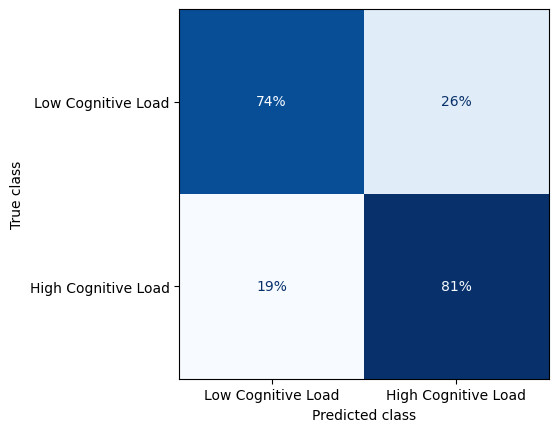

In [28]:
plot_confusion_matrix(
    results["true_values"],
    results["predicted_values"],
    ["Low Cognitive Load", "High Cognitive Load"], 
    normalize=True,
    output_dir=results["output_path"],
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   2 out of  21 | elapsed:    8.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:    8.7s remaining:   37.2s
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    8.9s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done   8 out of  21 | elapsed:    8.9s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:    9.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    9.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    9.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    9.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  18 out of  21 | elapsed:    9.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   10.3s finished


Macro F1 score: 0.840
Accuracy: 0.840



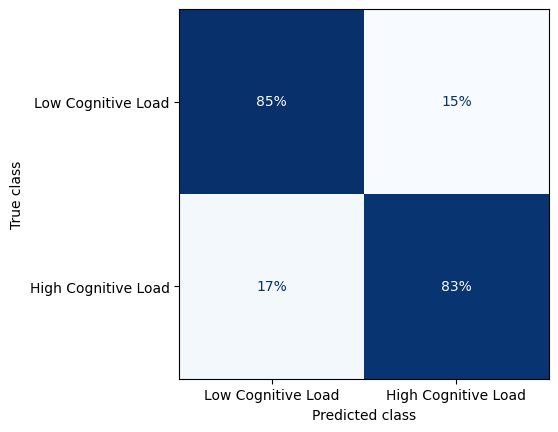

In [32]:
label_column_name = "cognitive_load"
sliding_window = (30, 1)
classifier = "logreg"
validation = "lopo"

results = classify(
    label_column_name,
    hololens_feature_df,
    sliding_window,
    classifier,
    validation,
    feature_importance=True
)

plot_confusion_matrix(
    results["true_values"],
    results["predicted_values"],
    ["Low Cognitive Load", "High Cognitive Load"], 
    normalize=True,
    output_dir=results["output_path"],
)

In [35]:
importance_df = results["importance_df"]
importance_df["abs_importance"] = importance_df["importance"].abs()
importance_df = importance_df.sort_values("abs_importance", ascending=False)
importance_df.head(15)

,importance,p03,p04,p05,p06,p07,p08,p09,p10,p11,...,p15,p16,p17,p19,p20,p21,p22,p23,p24,abs_importance
fixation_distance_energy,5.619,6.153,5.359,5.481,5.124,5.683,6.096,5.628,4.025,5.414,...,5.887,5.574,5.982,4.840,5.577,7.006,6.039,5.025,5.579,5.619
fixation_distance_skew,5.168,5.194,5.485,5.059,4.678,5.061,6.844,4.982,4.361,5.220,...,5.025,4.593,5.184,5.399,4.975,5.627,5.143,5.413,5.068,5.168
hand_max_contralateral_distance_mean,-3.422,-3.842,-4.016,-3.526,-3.375,-2.842,-2.962,-3.692,-3.528,-3.456,...,-3.305,-3.274,-2.778,-2.690,-3.684,-3.745,-3.663,-3.861,-3.519,3.422
hand_max_contralateral_distance_rms,-3.012,-2.934,-3.100,-3.238,-2.996,-3.180,-2.749,-3.275,-2.741,-3.243,...,-3.472,-3.412,-3.051,-1.866,-3.455,-2.625,-3.500,-3.412,-3.200,3.012
head_up_angular_distance_iqr,-2.928,-3.163,-2.934,-2.767,-3.315,-2.775,-3.038,-2.848,-2.553,-2.972,...,-2.964,-2.299,-3.161,-3.640,-3.210,-2.442,-3.029,-2.950,-2.970,2.928
fixation_distance_kurtosis,2.493,2.382,2.575,2.421,2.310,2.537,2.982,2.334,2.161,2.310,...,2.583,2.314,2.516,3.041,2.401,2.391,2.495,2.725,2.454,2.493
head_forward_angular_distance_mad,2.469,2.259,2.745,2.450,2.739,1.863,2.324,2.324,1.984,3.065,...,2.249,2.753,2.227,2.319,2.408,2.711,2.741,2.627,2.360,2.469
hand_max_position_change_skew,-2.073,-2.282,-2.242,-2.075,-1.956,-2.003,-2.199,-2.086,-2.209,-2.030,...,-1.994,-1.895,-1.574,-1.970,-2.253,-1.760,-2.214,-1.688,-2.156,2.073
hand_max_contralateral_distance_std,1.989,1.796,1.969,1.565,2.047,2.296,1.508,1.854,1.749,2.153,...,2.343,2.485,2.109,2.470,2.150,1.969,2.175,2.169,2.125,1.989
hand_max_position_change_iqr,-1.967,-1.869,-2.070,-1.743,-1.846,-1.648,-1.920,-1.980,-2.326,-1.860,...,-1.902,-1.862,-2.667,-1.933,-1.776,-1.573,-1.953,-2.343,-1.793,1.967


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   2 out of  19 | elapsed:    2.1s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    2.2s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:    2.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    2.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  19 | elapsed:    2.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    2.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.4s finished


Macro F1 score: 0.576
Accuracy: 0.577



c:\Users\melo\Projects\tangram-cognitive-load\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


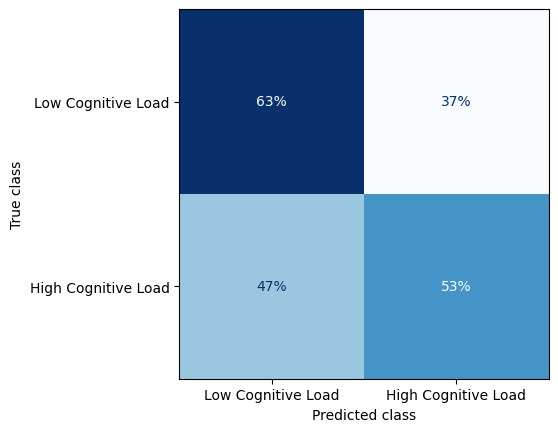

In [31]:
label_column_name = "cognitive_load"
sliding_window = (30, 1)
classifier = "logreg"
validation = "lopo"

results = classify(
    label_column_name,
    e4_feature_df,
    sliding_window,
    classifier,
    validation,
    feature_importance=True
)

plot_confusion_matrix(
    results["true_values"],
    results["predicted_values"],
    ["Low Cognitive Load", "High Cognitive Load"], 
    normalize=True,
    output_dir=results["output_path"],
)